In [1]:
import sentencepiece as spm
from gensim.models import Word2Vec

In [2]:
# Load BPE model
sp_bpe = spm.SentencePieceProcessor()
sp_bpe.load("../tokenizer/spbpe_isc_1000.model")

True

In [3]:
def tokenize_with_bpe(sp_bpe, words):
    bpe_tokenized = []
    for word in words:
        tokens = sp_bpe.encode(word, out_type=str)  # Adjust output type as needed
        bpe_tokenized.extend(tokens)  # Join tokens with space
    return bpe_tokenized

In [4]:
with open('../data/isc_sentences.txt', 'r') as f:
    sentences = f.readlines()

In [5]:
sentences_bpe = [tokenize_with_bpe(sp_bpe, sentence.split()) for sentence in sentences]

In [16]:
import random
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from gensim.models import Word2Vec

param_grid = [
    {"vector_size": 100, "window": 5, "min_count": 1},
    {"vector_size": 128, "window": 5, "min_count": 1},
    {"vector_size": 254, "window": 5, "min_count": 1},
    {"vector_size": 300, "window": 5, "min_count": 1},
    
    {"vector_size": 128, "window": 10, "min_count": 1},
    {"vector_size": 254, "window": 10, "min_count": 1},
    {"vector_size": 300, "window": 10, "min_count": 1},
    
    {"vector_size": 128, "window": 5, "min_count": 2},
    {"vector_size": 150, "window": 5, "min_count": 2},
    {"vector_size": 254, "window": 5, "min_count": 2},
    {"vector_size": 300, "window": 5, "min_count": 2},
    
    {"vector_size": 128, "window": 10, "min_count": 2},
    {"vector_size": 254, "window": 10, "min_count": 2},
    {"vector_size": 300, "window": 10, "min_count": 2},
    
    {"vector_size": 128, "window": 5, "min_count": 3},
    {"vector_size": 254, "window": 5, "min_count": 3},
    {"vector_size": 300, "window": 5, "min_count": 3},
    
    {"vector_size": 128, "window": 10, "min_count": 3},
    {"vector_size": 254, "window": 10, "min_count": 3},
    {"vector_size": 300, "window": 10, "min_count": 3},
]


# Function to evaluate Word2Vec model
def train_and_evaluate(params, train_sentences, test_sentences, num_clusters=10):
    # Train the Word2Vec model
    model = Word2Vec(sentences=train_sentences, 
                     vector_size=params["vector_size"], 
                     window=params["window"], 
                     min_count=params["min_count"], 
                     workers=4)
    
    # 1. Calculate similarity score (for consecutive words in the test set)
    similarity_score = 0
    for sentence in test_sentences:
        for i in range(1, len(sentence)):
            try:
                similarity_score += model.wv.similarity(sentence[i-1], sentence[i])
            except KeyError:
                # If a word is not in the vocabulary, skip it
                continue
    
    # 2. Get the word vectors for all words in the vocabulary
    word_vectors = np.array([model.wv[word] for word in model.wv.index_to_key])
    
    # 3. Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(word_vectors)
    
    # 4. Calculate Silhouette Score
    silhouette_avg = silhouette_score(word_vectors, kmeans.labels_)
    
    # Return both similarity score and silhouette score
    return similarity_score, silhouette_avg

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
results = []

for params in param_grid:
    fold_scores = []
    sil_scores = []
    for train_index, test_index in kf.split(sentences_bpe):
        train_sentences = [sentences_bpe[i] for i in train_index]
        test_sentences = [sentences_bpe[i] for i in test_index]
        
        score, sil = train_and_evaluate(params, train_sentences, test_sentences)
        fold_scores.append(score)
        sil_scores.append(sil)
    
    avg_score = sum(fold_scores) / len(fold_scores)
    avg_sil = sum(sil_scores) / len(sil_scores)
    results.append((params, avg_score, avg_sil))

# Print results
for params, avg_score, avg_sil in results:
    print(f"Params: {params}, Average Score: {avg_score}, Silueta Score: {avg_sil}")

Params: {'vector_size': 100, 'window': 5, 'min_count': 1}, Average Score: 3945.2530430659654, Silueta Score: 0.3760015547275543
Params: {'vector_size': 128, 'window': 5, 'min_count': 1}, Average Score: 3952.6270122000947, Silueta Score: 0.39278229475021365
Params: {'vector_size': 254, 'window': 5, 'min_count': 1}, Average Score: 3971.0120304465295, Silueta Score: 0.4254909336566925
Params: {'vector_size': 300, 'window': 5, 'min_count': 1}, Average Score: 3974.941155028343, Silueta Score: 0.4273956835269928
Params: {'vector_size': 128, 'window': 10, 'min_count': 1}, Average Score: 3969.3061346977947, Silueta Score: 0.42748435139656066
Params: {'vector_size': 254, 'window': 10, 'min_count': 1}, Average Score: 3982.599282681942, Silueta Score: 0.45623438954353335
Params: {'vector_size': 300, 'window': 10, 'min_count': 1}, Average Score: 3985.5534107804297, Silueta Score: 0.4709761321544647
Params: {'vector_size': 128, 'window': 5, 'min_count': 2}, Average Score: 3932.9286389481276, Siluet

In [6]:
sentences_bpe = [tokenize_with_bpe(sp_bpe, sentence.split()) for sentence in sentences]

# Train Word2Vec model on BPE tokenized sentences
w2v_bpe = Word2Vec(sentences_bpe, vector_size=300, window=10, min_count=1, workers=4)

In [7]:
w2v_bpe.save("iscbpe2vec.model")

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings_2D(words, vectors, dimension='tsne'):
    """Visualize word vectors in 2D using t-SNE or PCA."""
    # Reduce dimensionality using t-SNE
    if dimension == 'tsne':
        perplexity = min(30, len(words) - 1)  # Ensure perplexity is less than the number of samples
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
        reduced_vectors = tsne.fit_transform(vectors)
    # Reduce dimensionality using PCA
    # elif dimension == 'pca':
    #     pca = PCA(n_components=2)
    #     reduced_vectors = pca.fit_transform(vectors)
    else:
        raise ValueError("Invalid dimension specified. Use 'tsne' or 'pca'.")

    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

    # Annotate each point with the corresponding word
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)

    plt.title(f'Visualización 2D de los vectores - BPE tokenizer y word2vec ({dimension.upper()})')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid()
    plt.show()

In [11]:
# read word list from file
with open('../morfessor/isc_words_lower.txt', 'r') as f:
    words = f.readlines()

In [12]:
# segment the words using BPE
words_bpe = [tokenize_with_bpe(sp_bpe, word.split()) for word in words]
# obtain the vectors for each subword and average them to get the vector for the word
vectors = []
for word in words_bpe:
    vectors.append(np.mean([w2v_bpe.wv[subword] for subword in word], axis=0))

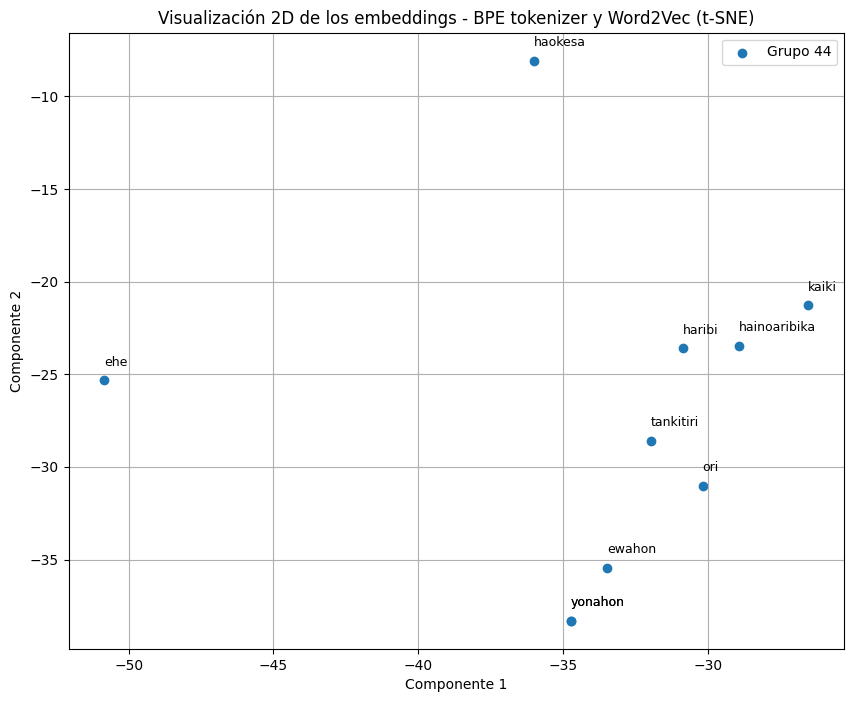

In [90]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
# cluster the vectors, plot 2 clusters in 2D with t-SNE, and color the points accordingly, and annotate them with the word
def cluster_embeddings(vectors, words, n_clusters=5, clusters_to_plot=[0, 1], max_words_per_cluster=10):
    """
    Cluster the vectors, plot 2 clusters in 2D with t-SNE, and color the points accordingly, and annotate them with the word.
    Plot a maximum of 10 words per cluster.

    Args:
        vectors (list): List of word vectors.
        words (list): List of words corresponding to the vectors.
        n_clusters (int): Number of clusters to identify.
        clusters_to_plot (list): List of cluster indices to plot.
        max_words_per_cluster (int): Maximum number of words to plot per cluster.
    """
    # Convert vectors to a NumPy array
    vectors = np.array(vectors)
    
    # Cluster the vectors using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
    clusters = kmeans.labels_
    
    # Reduce dimensionality using t-SNE
    perplexity = min(30, len(words) - 1)  # Ensure perplexity is less than the number of samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    reduced_vectors = tsne.fit_transform(vectors)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    for cluster in clusters_to_plot:
        indices = [i for i, c in enumerate(clusters) if c == cluster]
        # Limit the number of words plotted per cluster
        indices = indices[:max_words_per_cluster]
        plt.scatter(reduced_vectors[indices, 0], reduced_vectors[indices, 1], label=f'Grupo {cluster}')
        for i in indices:
            plt.annotate(words[i], (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=9)
    
    plt.title('Visualización 2D de los embeddings - BPE tokenizer y Word2Vec (t-SNE)')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend()
    plt.grid()
    plt.show()

cluster_embeddings(np.array(vectors), words, n_clusters=100, clusters_to_plot=[44])

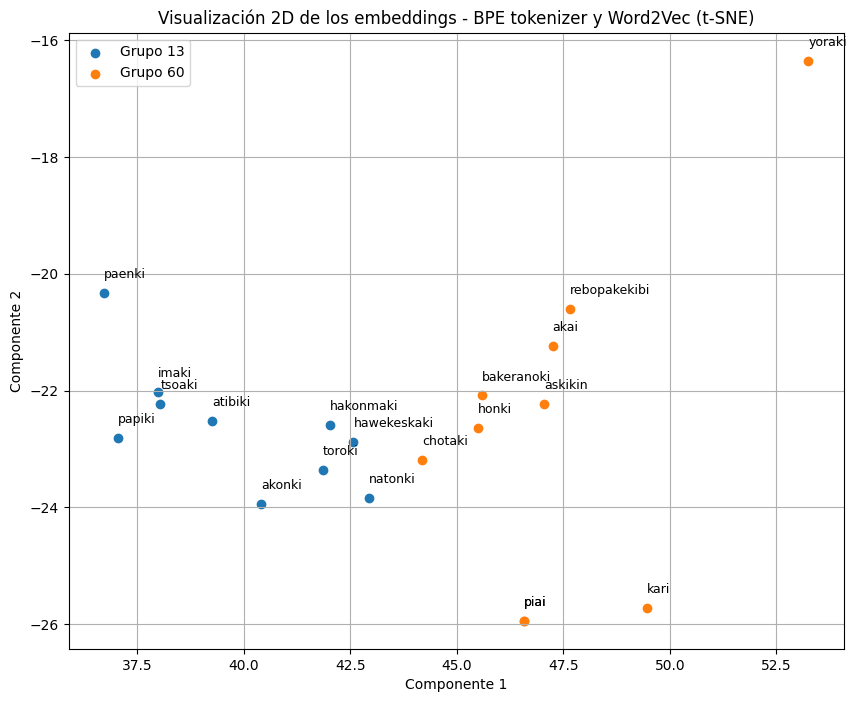

In [86]:
cluster_embeddings(np.array(vectors), words, n_clusters=100, clusters_to_plot=[13, 60])

In [ ]:
# get 20 random words vectors
np.random.seed(0)
random_indices = np.random.choice(len(words), 20, replace=False)
random_words = [words[i] for i in random_indices]
random_vectors = [vectors[i] for i in random_indices]
random_vectors = np.array(random_vectors)

In [ ]:
# import random
# word_list = list(w2v_bpe.wv.key_to_index.keys())
# # Sample 20 words from the list
# sampled_words = random.sample(word_list, 20)
# # Get the word vectors for the sampled words
# word_vectors = np.array([w2v_bpe.wv[word] for word in sampled_words])

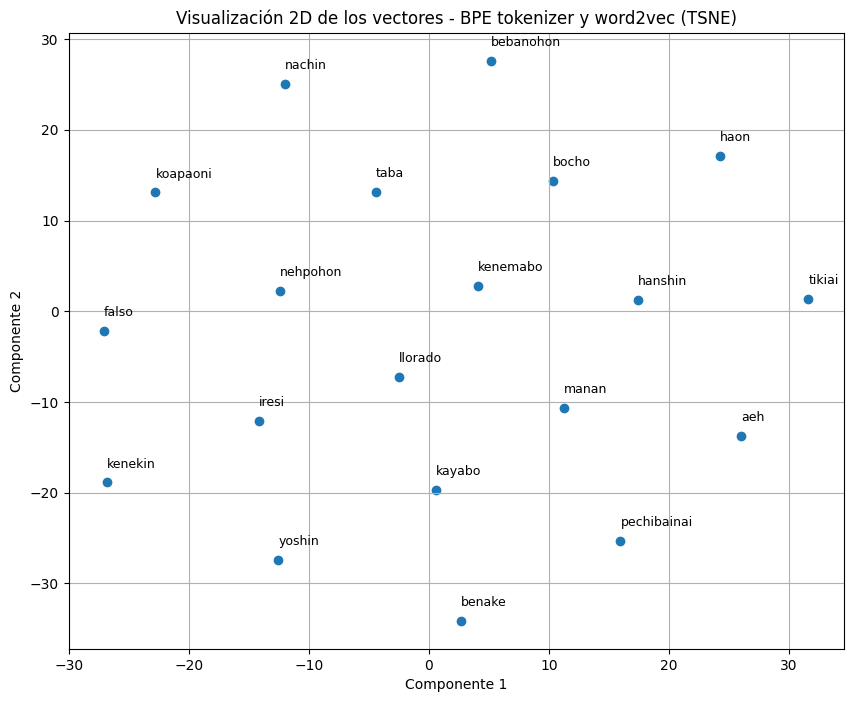

In [17]:
visualize_embeddings_2D(random_words,random_vectors)